# TP2
Very Large Graph

Exercice de recherche de cliques maximales dans un Graphe

Ressources :
https://fr.wikipedia.org/wiki/Clique_(th%C3%A9orie_des_graphes)
https://fr.wikipedia.org/wiki/Algorithme_de_Bron-Kerbosch
https://fr.wikipedia.org/wiki/D%C3%A9g%C3%A9n%C3%A9rescence_(th%C3%A9orie_des_graphes)

Implémentation en Python en suivant ces pseudo-codes :

Il s’agira cette fois de réaliser les implémentations de manière parallélisé.
Pour rappel, le multi-threading n’existe pas vraiment en Python à cause du GIL (possibilité de suppression dans les prochaines versions).
Librairies de multithreading en Python

En Python, il existe plusieurs bibliothèques pour gérer le multithreading. Voici quelques-unes des plus couramment utilisées :

1. **`threading`** : Il s'agit du module standard pour le multithreading en Python.
   - Il fournit des classes pour la création et la gestion de threads, ainsi que des primitives de synchronisation telles que les verrous et les sémaphores.
   - Exemple :
     ```python
     import threading

     def thread_function():
         # Code à exécuter dans le thread

     thread = threading.Thread(target=thread_function)
     thread.start()
     thread.join()
     ```
   
2. **`queue`** : Utilisé en combinaison avec `threading` pour fournir un moyen sûr de communiquer entre les threads.
   - Il est particulièrement utile pour implémenter des modèles de type producteur-consommateur.
   - Les queues thread-safe garantissent que les données sont ajoutées ou retirées d'une manière qui ne causera pas de conditions de concurrence.

3. **`concurrent.futures`** : Introduit dans Python 3.2, il offre une interface de haut niveau pour la création et la gestion de threads et de processus.
   - Le module fournit une classe `ThreadPoolExecutor` qui facilite la création et la gestion de pools de threads.
   - Exemple :
     ```python
     from concurrent.futures import ThreadPoolExecutor

     with ThreadPoolExecutor() as executor:
         future = executor.submit(function_name, arg1, arg2)
         return_value = future.result()
     ```

4. **`multiprocessing`** : Bien que ce module soit principalement conçu pour le multiprocessing (c'est-à-dire l'utilisation de plusieurs processus plutôt que de threads), il possède une interface similaire à celle du module `threading`, ce qui peut le rendre utile dans certains contextes où les threads ne sont pas appropriés en raison du Global Interpreter Lock (GIL) en Python.
  
5. **`asyncio`** : Introduit dans Python 3.3, il offre un cadre pour écrire des programmes concurrents à l'aide de coroutines. Bien qu'il ne s'agisse pas techniquement de multithreading, il permet une exécution concurrente et est souvent utilisé dans des situations où le multithreading pourrait également être considéré.

## Import

In [141]:
import networkx as nx
from itertools import combinations
from multiprocessing import Pool, Manager
from threading import Thread, Lock
import matplotlib.pyplot as plt
from copy import deepcopy

## Tested graph

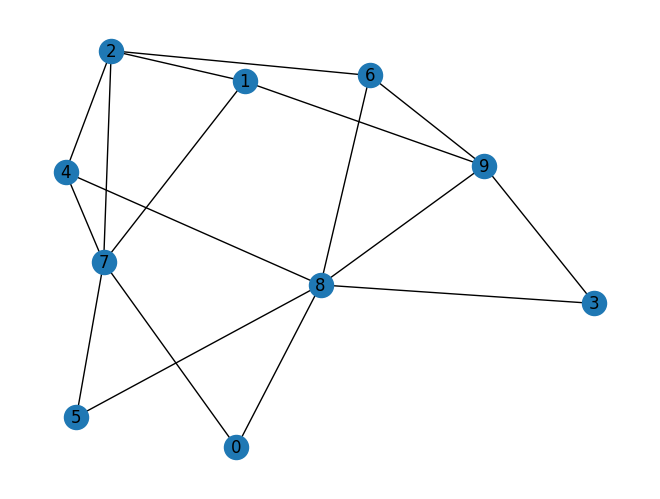

In [142]:
# Test the above functions
G = nx.erdos_renyi_graph(10, 0.5)
nx.draw(G, with_labels=True)
plt.show()

Il est essentiel de noter que, en raison du Global Interpreter Lock (GIL) en CPython (l'implémentation standard de Python), le multithreading peut ne pas offrir une amélioration significative des performances pour les tâches intensives en CPU. Dans de tels cas, le multiprocessing ou l'utilisation d'une autre implémentation de Python (comme Jython ou IronPython) pourrait être une meilleure option.

Les graphes seront représentés avec Networkx, l’affichage avec Matplotlib et les graphes peuvent être généré de manière aléatoire (par exemple Erdos Renyi https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.erdos_renyi_graph.html)

## Simple/naïf
```
fonction recherche_clique(graphe G):
    n = nombre de sommets de G
    taille_max_clique = 0
    clique_max = ensemble vide
    
    pour chaque sous-ensemble S de sommets de G:
        si la taille de S > taille_max_clique et est_clique(G, S):
            taille_max_clique = taille de S
            clique_max = S
            
    retourner clique_max

fonction est_clique(graphe G, ensemble S):
    pour chaque paire de sommets v, w dans S:
        si v n'est pas adjacent à w dans G:
            retourner faux
    retourner vrai
```

In [143]:
def est_clique(G, noeuds):
    for v in noeuds:
        for w in noeuds:
            if v != w and not G.has_edge(v, w):
                return False
    return True

def recherche_clique_process(G, sous_ensembles, resultats, lock):
    for S in sous_ensembles:
        if len(S) > resultats['taille'] and est_clique(G, S):
            with lock:
                if len(S) > resultats['taille']:
                    resultats['taille'] = len(S)
                    resultats['clique'] = S

def recherche_clique_naif_multithread(G, pool_size=4):
    n = G.number_of_nodes()
    tous_noeuds = list(G.nodes)
    sous_ensembles = [combinations(tous_noeuds, r) for r in range(n+1)]

    with Manager() as manager:
        resultats = manager.dict(taille=0, clique=[])
        lock = manager.Lock()

        with Pool(processes=pool_size) as pool:
            pool.starmap(recherche_clique_process, [(G, sous_ensemble, resultats, lock) for sous_ensemble in sous_ensembles])

        return set(resultats['clique'])

In [144]:
%%time
clique_max = recherche_clique_naif_multithread(G)
print("La plus grande clique est :", clique_max)

La plus grande clique est : {1, 2, 7}
CPU times: user 25.5 ms, sys: 59 ms, total: 84.5 ms
Wall time: 149 ms


## Bron Kerbosch
```
algorithme BronKerbosch1(R, P, X)
    si P et X sont vides alors
        déclarer que R est une clique maximale
    pour tout sommet v dans P faire
        BronKerbosch1(R ⋃ {v}, P ⋂ N(v), X ⋂ N(v))
        P := P \ {v}
        X := X ⋃ {v}

BronKerbosch1(∅, V, ∅) //appel initial
```

In [145]:
def BronKerbosch1(R, P, X, cliques, lock):
    if not P and not X:
        with lock:
            cliques.append(R)
    else:
        for v in list(P):
            Nv = set(G.adj[v])
            BronKerbosch1(R.union([v]), P.intersection(Nv), X.intersection(Nv), cliques, lock)
            P.remove(v)
            X.add(v)

def parallel_bron_kerbosch(G):
    manager = Manager()
    cliques = manager.list()
    lock = manager.Lock()
    P = set(G.nodes())
    X = set()
    R = set()

    with Pool() as pool:
        tasks = [(deepcopy(R), P.intersection(set(G.adj[v])), X.intersection(set(G.adj[v])), cliques, lock) for v in P]
        pool.starmap_async(BronKerbosch1, tasks)

        pool.close()
        pool.join()

    return list(cliques)

In [146]:
%%time
max_cliques = parallel_bron_kerbosch(G)
print("Les cliques maximales sont : {}".format(max_cliques))

Les cliques maximales sont : [{9}, {8}, {1, 7}, {7}, {2, 7}, {8, 9}, {8}, {8}, {4, 7}, {8, 9}, {0}, {0}, {8, 3}, {2, 7}, {6}, {7}, {2}, {1, 2}, {9, 3}, {8, 6}, {2, 4}, {4}, {1}, {5}, {5}, {9, 6}]
CPU times: user 17.7 ms, sys: 188 ms, total: 206 ms
Wall time: 268 ms


## Bron Kerbosch pivot
```
algorithme BronKerbosch2(R, P, X)
    si P et X sont vides alors
        déclarer que R est une clique maximale
    choisir un sommet pivot u dans P ⋃ X
    pour tout sommet v dans P \ N(u) faire
        BronKerbosch2(R ⋃ {v}, P ⋂ N(v), X ⋂ N(v))
        P := P \ {v}
        X := X ⋃ {v}
```

In [147]:
def BronKerbosch2(R, P, X, cliques, lock, G):
    if not P and not X:
        with lock:
            cliques.append(R)
    else:
        u = None
        for node in P.union(X):
            if u is None or len(G.adj[node]) > len(G.adj[u]):
                u = node  # Choisir le pivot comme le sommet avec le plus grand nombre de voisins
        for v in P - set(G.adj[u]):
            Nv = set(G.adj[v])
            BronKerbosch2(R.union([v]), P.intersection(Nv), X.intersection(Nv), cliques, lock, G)
            P.remove(v)
            X.add(v)

def parallel_bron_kerbosch_pivot(G):
    P = set(G.nodes())
    R = set()
    X = set()
    cliques = []
    lock = Lock()

    threads = []
    u = None
    for node in P.union(X):
        if u is None or len(G.adj[node]) > len(G.adj[u]):
            u = node  # Choisir le pivot
    for v in P - set(G.adj[u]):
        Nv = set(G.adj[v])
        t = Thread(target=BronKerbosch2, args=(R.union([v]), P.intersection(Nv), X.intersection(Nv), cliques, lock, G))
        t.start()
        threads.append(t)

    for t in threads:
        t.join()

    return cliques

In [148]:
%%time
max_cliques = parallel_bron_kerbosch_pivot(G)
print("Les cliques maximales sont :", max_cliques)

Les cliques maximales sont : [{8, 0}, {8, 9, 3}, {8, 9, 6}, {8, 4}, {8, 5}, {1, 9}, {1, 2, 7}, {2, 6}, {1, 2, 7}, {2, 4, 7}, {0, 7}, {1, 2, 7}, {2, 4, 7}, {5, 7}]
CPU times: user 0 ns, sys: 1.11 ms, total: 1.11 ms
Wall time: 807 µs


## Bron Kerbosch pivot et dégénérescence
```
algorithme BronKerbosch3(G)
    P = V(G)
    R = Ø
    X = Ø
    pour tout sommet v visités dans un ordre de dégénérescence de G faire
        BronKerbosch2({v}, P ⋂ N(v), X ⋂ N(v))
        P := P \ {v}
        X := X ⋃ {v}
```

In [149]:
def parallel_bron_kerbosch_pivot(G):
    P = set(G.nodes())
    R = set()
    X = set()
    cliques = []
    lock = Lock()

    threads = []
    u = None
    for node in P.union(X):
        if u is None or len(G.adj[node]) > len(G.adj[u]):
            u = node  # Choisir le pivot
    for v in P - set(G.adj[u]):
        Nv = set(G.adj[v])
        t = Thread(target=BronKerbosch2, args=(R.union([v]), P.intersection(Nv), X.intersection(Nv), cliques, lock, G))
        t.start()
        threads.append(t)

    for t in threads:
        t.join()

    return cliques

In [150]:
%%time
max_cliques = parallel_bron_kerbosch_pivot(G)
print("Les cliques maximales sont :", max_cliques)

Les cliques maximales sont : [{8, 0}, {8, 9, 3}, {8, 9, 6}, {8, 4}, {8, 5}, {1, 9}, {1, 2, 7}, {2, 6}, {1, 2, 7}, {2, 4, 7}, {0, 7}, {1, 2, 7}, {2, 4, 7}, {5, 7}]
CPU times: user 1.23 ms, sys: 0 ns, total: 1.23 ms
Wall time: 813 µs



## Dégénérescence


- Initialiser la liste de sortie L à la liste vide.
- Calculer une valeur dv pour chaque sommet v de G, qui est le nombre de voisins de v qui n'est pas déjà dans L (initialement, il s'agit donc du degré des sommets dans G).
- Initialiser un tableau D tel que D[i] contienne la liste des sommets v qui ne sont pas déjà dans L pour lesquels dv = i.
- Initialiser la valeur k à 0.
- Répéter n fois:
        - Parcourir les cellules du tableau D[0], D[1], ... jusqu'à trouver un i pour lequel D[i] est non-vide.
        - Mettre k à max(k,i).
        - Sélectionner un sommet v de D[i], ajouter v en tête de L et le retirer de D[i].
        - Pour chaque voisin w de v qui n'est pas déjà dans L, retirer une unité de dw et déplacer w de la cellule de D correspondant à la nouvelle valeur de dw.

In [151]:
def degeneracy_order(G):
    n = G.number_of_nodes()
    L = []
    degrees = {v: len(list(G.neighbors(v))) for v in G.nodes()}
    D = [[] for _ in range(max(degrees.values()) + 1)]
    for v, d in degrees.items():
        D[d].append(v)
    k = 0

    for _ in range(n):
        for i, vertices in enumerate(D):
            if vertices:
                k = max(k, i)
                break
        v = vertices.pop()
        L.append(v)
        for w in G.neighbors(v):
            if w not in L:
                degree_w = degrees[w]
                D[degree_w].remove(w)
                D[degree_w - 1].append(w)
                degrees[w] -= 1

    return L, k

In [152]:
%%time
L, k = degeneracy_order(G)
print("L'ordre de dégénérescence est :", L)
print("La valeur de dégénérescence est :", k)

L'ordre de dégénérescence est : [5, 3, 0, 8, 9, 6, 1, 7, 4, 2]
La valeur de dégénérescence est : 3
CPU times: user 140 µs, sys: 0 ns, total: 140 µs
Wall time: 134 µs


## PySpark

Même exercice que précédemment, en implémentant les différentes versions d’algorithmes de recherches de cliques maximales dans un graphe non-orienté et connexe en utilisant Spark pour cette fois paralléliser, l’avantage est que les fonctions d'agrégation (map, reduce, filter) pourront être distribuées sur plusieurs machines.
Attention, installation de Spark et Java 8.


In [153]:
from pyspark import SparkContext, AccumulatorParam

## Bron Kerbosch pivot with PySpark

In [154]:
class ListAccumulatorParam(AccumulatorParam):
    def zero(self, initialValue):
        return []

    def addInPlace(self, v1, v2):
        v1.extend(v2)
        return v1

def bron_kerbosch(R, P, X, graph_broadcast):
    if not P and not X:
        yield tuple(R)
    else:
        u = next(iter(P.union(X)))  # Choose a pivot
        neighbors_u = set(graph_broadcast.value[u])
        for v in P - neighbors_u:
            neighbors_v = set(graph_broadcast.value[v])
            yield from bron_kerbosch(R.union([v]), P.intersection(neighbors_v), X.intersection(neighbors_v), graph_broadcast)
            P.remove(v)
            X.add(v)

def execute_bron_kerbosch(graph):
    sc = SparkContext.getOrCreate()
    graph_dict = {node: set(neighbors) for node, neighbors in nx.to_dict_of_lists(graph).items()}
    graph_broadcast = sc.broadcast(graph_dict)
    cliques_accum = sc.accumulator([], ListAccumulatorParam())

    P = set(graph_dict.keys())
    X = set()
    R = set()

    cliques_rdd = sc.parallelize(graph_dict.keys()).flatMap(lambda v: bron_kerbosch(R.union([v]), P.intersection(graph_dict[v]), X, graph_broadcast))

    # Here we are adding the result to the accumulator
    cliques_rdd.foreach(lambda c: cliques_accum.add([c]))

    sc.stop()

    # Remove duplicates and sort the tuples for comparison
    max_cliques = list(set(map(tuple, map(sorted, cliques_accum.value))))
    return max_cliques


In [155]:
%%time
max_cliques = execute_bron_kerbosch(G)
print("Les cliques maximales sont :", max_cliques)

Les cliques maximales sont : [(1, 2, 7), (0, 7), (5, 8), (2, 4, 7), (5, 7), (6, 8, 9), (3, 8, 9), (2, 6), (4, 8), (0, 8), (1, 9)]
CPU times: user 963 µs, sys: 16.8 ms, total: 17.7 ms
Wall time: 1.79 s


## Bron Kerbosch pivot et dégénérescence avec PySpark

In [156]:
def bron_kerbosch_pivot(R, P, X, graph_broadcast):
    if not P and not X:
        yield tuple(R)  # Convert set R to a tuple before yielding
    else:
        u = max(P.union(X), key=lambda v: len(graph_broadcast.value[v]))
        for v in P - set(graph_broadcast.value[u]):
            yield from bron_kerbosch_pivot(
                R.union([v]),
                P.intersection(graph_broadcast.value[v]),
                X.intersection(graph_broadcast.value[v]),
                graph_broadcast
            )
            P.remove(v)
            X.add(v)

In [157]:
def parallel_bron_kerbosch3(sc, graph):
    graph_dict = {node: set(neighbors) for node, neighbors in nx.to_dict_of_dicts(graph).items()}
    graph_broadcast = sc.broadcast(graph_dict)
    ordering = degeneracy_order(graph)[0]

    # Parallelize the execution using the degeneracy ordering
    cliques_rdd = sc.parallelize(ordering).flatMap(
        lambda v: bron_kerbosch_pivot(
            {v},
            set(graph_dict[v]),
            set(),
            graph_broadcast
        )
    )

    max_cliques = cliques_rdd.distinct().collect()
    return max_cliques

In [158]:
%%time

sc = SparkContext(appName="BronKerbosch")
max_cliques = parallel_bron_kerbosch3(sc, G)
sc.stop()

print("The maximal cliques found are:", max_cliques)

The maximal cliques found are: [(5, 7), (0, 8), (8, 0), (8, 9, 6), (9, 1), (1, 9), (1, 2, 7), (2, 4, 7), (2, 6), (8, 9, 3), (8, 5), (8, 4), (0, 7)]
CPU times: user 16.5 ms, sys: 0 ns, total: 16.5 ms
Wall time: 1.83 s
